In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import ndimage
import imageio
import os
import glob
import h5py as h5
import re

import matplotlib.animation as anim

import time
from progress import ProgressBar, query_yes_no

%matplotlib inline

In [2]:
mpl.rcParams['figure.figsize'] = 16, 12  # that's default image size for this interactive session

# Load an image 

In [9]:
filedir = '/Volumes/Data/Muscle fibers/Drerio_7_curved_recon'
files = glob.glob(os.path.join(filedir,'Drerior_5-7_curved_scan_rec[0-9][0-9][0-9][0-9].tif'))
files = sorted(files)

In [10]:
frames = [1570, 2121]

In [11]:
prog = re.compile('rec(\d{4})\.tif')
filenum = []
for fn in files:
    res = prog.search(fn)
    filenum.append(int(res.group(1)))

In [12]:
files = [fn for fn,num in zip(files,filenum) if num >= frames[0] and num <= frames[1]]

In [13]:
len(files)

552

In [14]:
print(files[0])
print(files[-1])

/Volumes/Data/Muscle fibers/Drerio_7_curved_recon/Drerior_5-7_curved_scan_rec1570.tif
/Volumes/Data/Muscle fibers/Drerio_7_curved_recon/Drerior_5-7_curved_scan_rec2121.tif


In [15]:
I = imageio.imread(files[350])

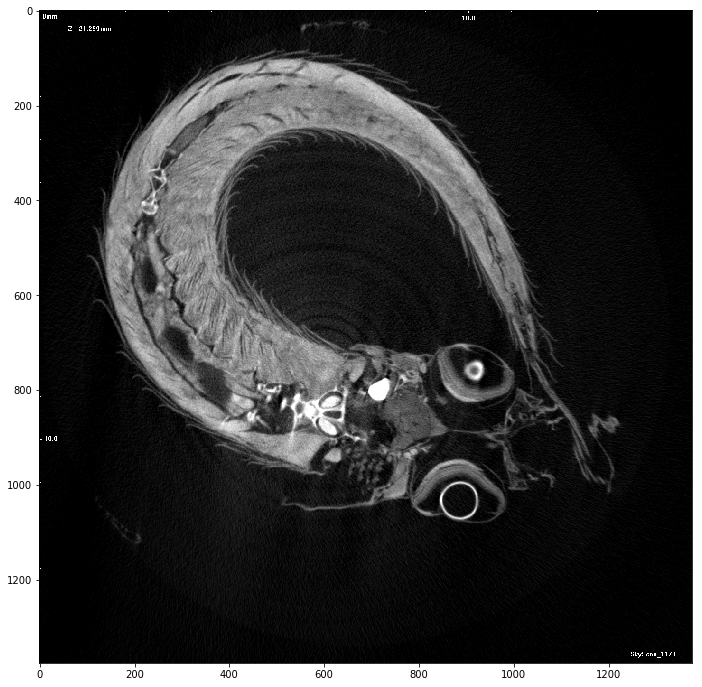

In [16]:
plt.imshow(I, cmap=mpl.cm.gray)
plt.show()

In [17]:
print(I.shape)

(1376, 1376)


Crop the image

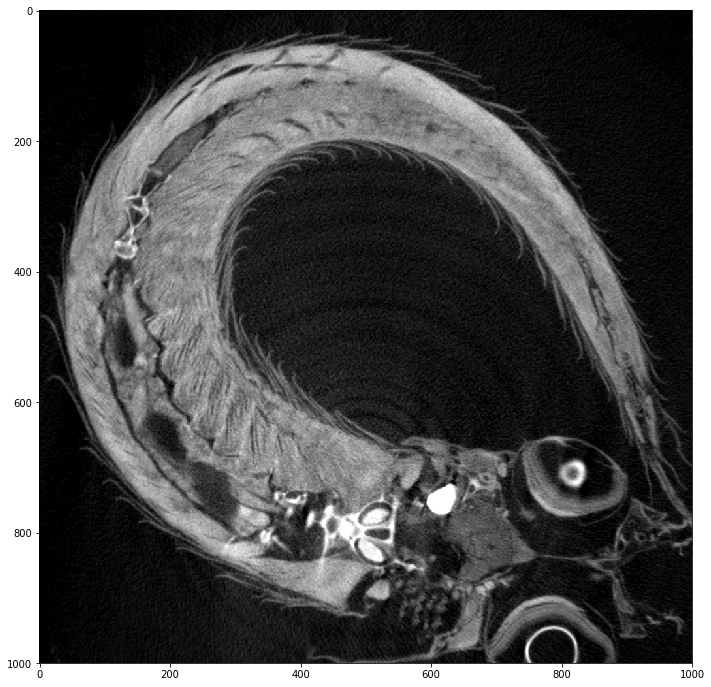

In [18]:
crop = (slice(50,1050),slice(100,1100))
plt.imshow(I[crop], cmap=mpl.cm.gray)
plt.show()

## Check crop on other images

/Volumes/Data/Muscle fibers/Drerio_7_curved_recon/Drerior_5-7_curved_scan_rec1602.tif
/Volumes/Data/Muscle fibers/Drerio_7_curved_recon/Drerior_5-7_curved_scan_rec1635.tif
/Volumes/Data/Muscle fibers/Drerio_7_curved_recon/Drerior_5-7_curved_scan_rec1667.tif
/Volumes/Data/Muscle fibers/Drerio_7_curved_recon/Drerior_5-7_curved_scan_rec1700.tif
/Volumes/Data/Muscle fibers/Drerio_7_curved_recon/Drerior_5-7_curved_scan_rec1732.tif
/Volumes/Data/Muscle fibers/Drerio_7_curved_recon/Drerior_5-7_curved_scan_rec1764.tif
/Volumes/Data/Muscle fibers/Drerio_7_curved_recon/Drerior_5-7_curved_scan_rec1797.tif
/Volumes/Data/Muscle fibers/Drerio_7_curved_recon/Drerior_5-7_curved_scan_rec1829.tif
/Volumes/Data/Muscle fibers/Drerio_7_curved_recon/Drerior_5-7_curved_scan_rec1862.tif
/Volumes/Data/Muscle fibers/Drerio_7_curved_recon/Drerior_5-7_curved_scan_rec1894.tif
/Volumes/Data/Muscle fibers/Drerio_7_curved_recon/Drerior_5-7_curved_scan_rec1927.tif
/Volumes/Data/Muscle fibers/Drerio_7_curved_recon/Drer

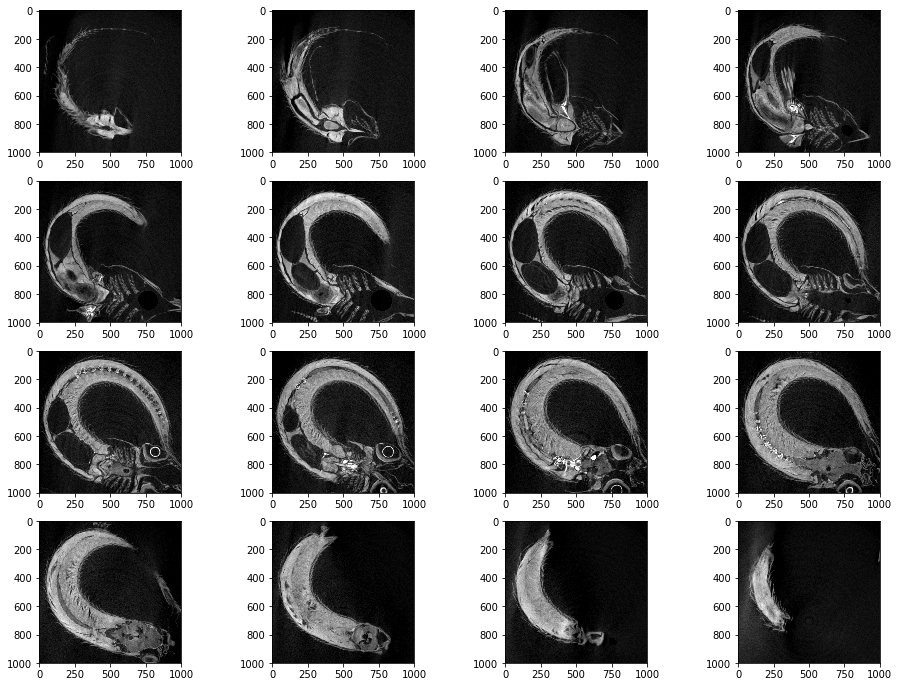

In [19]:
fig,ax = plt.subplots(4,4)
r = np.linspace(0,len(files)-1,18)
r = r[1:-1]
for ax,f in zip(ax.flat, r):
    print(files[int(round(f))])
    I1 = imageio.imread(files[int(round(f))])
    ax.imshow(I1[crop], cmap=mpl.cm.gray)
plt.show()

# Set up the file

In [20]:
outfile = 'Danio_16.h5'

## Make the image dataset

Warning!  This can take a long time

In [22]:
if not os.path.exists(outfile) or query_yes_no('Overwrite existing file?',default='no'):
    f = h5.File(outfile,'w-')
    
    imsz = list(I[crop].shape) + [len(files)]
    chunksz = (32,32,32)
    imgdata = f.create_dataset('image',imsz, chunks=chunksz, dtype=I.dtype)
    with ProgressBar(total=len(files)) as prog:
        for (i,filename) in enumerate(files):
            I1 = imageio.imread(files[i])
            imgdata[:,:,i] = I1[crop]
            prog.update(1)
    f.close()

 [------------------------------------------------------------>] 100%  13m 39sec elapsed, 0sec remaining None


# Make some animations

In [23]:
%matplotlib qt

In [24]:
imgfile = h5.File(outfile,'r')
imgdata = imgfile['image']
print(imgdata.shape)

(1000, 1000, 552)


In [25]:
frames = np.round(np.linspace(0,imgdata.shape[0],18))
frames = frames[1:-1]
for fr in frames:
    print("{}: [{},{}]".format(fr, np.min(imgdata[fr,:,:]), np.max(imgdata[fr,:,:])))

59.0: [0,52764]
118.0: [0,63937]
176.0: [0,65535]
235.0: [0,65535]
294.0: [0,65535]
353.0: [0,65535]
412.0: [0,64268]
471.0: [0,65535]
529.0: [0,60236]
588.0: [0,62380]
647.0: [0,65535]
706.0: [0,65535]
765.0: [0,65535]
824.0: [0,65535]
882.0: [0,65535]
941.0: [0,65535]


In [26]:
dpi = 96

In [27]:
def show_yz_slice(num, data, im):
    im.set_data(data[num,:,:].T)
    return im,

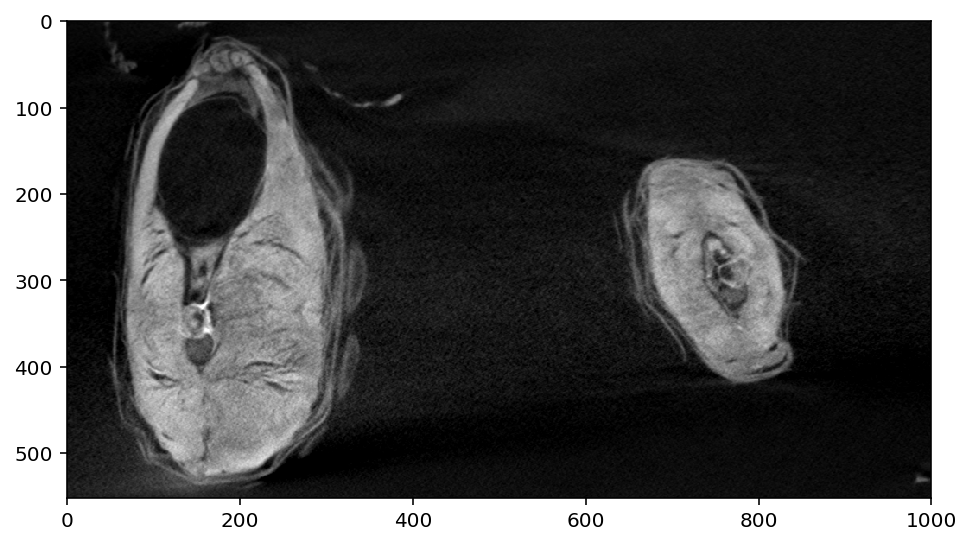

In [29]:
fig = plt.figure(frameon=False)

ax = plt.axes([0., 0., 1., 1.])
im = ax.imshow(imgdata[300,:,:].T, cmap=mpl.cm.gray, vmin=0, vmax=65536)

In [31]:
%matplotlib qt

fig = plt.figure(frameon=False)
fig.set_size_inches(imgdata.shape[1]/dpi, imgdata.shape[2]/dpi)

ax = plt.axes([0., 0., 1., 1.])
im = ax.imshow(imgdata[0,:,:].T, cmap=mpl.cm.gray, vmin=0, vmax=65536)

im_ani = anim.FuncAnimation(fig, show_yz_slice, frames=imgdata.shape[0], fargs=(imgdata, im), interval=50)
plt.show()

In [32]:
writer = anim.writers['ffmpeg'](fps=10, metadata=dict(artist='Eric Tytell'), bitrate=1800)

In [33]:
moviefile = 'Danio_16_test.mp4'

if not os.path.exists(moviefile):
    im_ani.save(moviefile, writer=writer)
else:
    print("File already exists!")